In [236]:
#ls -lt /lustre/BIF/nobackup/unen004/data

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set plot style
style.use('ggplot')

In [2]:
import os
import pickle

def load_pickle(fn, path):
    with open(os.path.join(path, '%s.pickle' % fn), 'rb') as f:
        df = pickle.load(f) 
    return df

# Load the CCA latent space of choice
spectral_type = 'spec2vec'
cca_type = 'cca'
latent_dims = 100

info = "- %s - %s - %s dims" % (spectral_type, cca_type, latent_dims)

df = load_pickle('dataframe_%s_%s_%d' % (spectral_type, cca_type, latent_dims), '/lustre/BIF/nobackup/unen004/data')
print("Spectra amount: %s" % len(df))

Spectra amount: 15145


In [12]:
# Define all plotting functions

def plot_views_per_set(df, method):
    """Plot train and test seperately, coloured by view (X and Y)."""
    g = sns.relplot(data=df, height=6, aspect=1, x=0, y=1, hue='view', col='set')
    g.fig.suptitle('%s %s' % (method, info), y=1.1, size='large', weight='semibold')

def plot_per_class(df, method, hue):
    """Plot all classes seperately, coloured by view or cf_class (hue).
    """
    g = sns.FacetGrid(df_umap_reduced, col='cf_class', hue=hue, col_wrap=5, height=3.5, aspect=1.2)
    g.map(sns.scatterplot, 0, 1)
    g.fig.suptitle('%s %s' % (method, info), y=1.1, size='large', weight='semibold')

In [13]:
# Prepare cca data, column for each dimension
cca_x = df['X'].apply(pd.Series)
cca_y = df['Y'].apply(pd.Series)
df_cca = pd.concat([cca_x, cca_y])
df_cca.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-1.543295,-0.078221,0.099546,-0.801720,0.073243,2.494815,0.428506,0.983098,1.133576,-0.480181,...,-0.173337,-0.596749,0.766707,-0.181632,-1.198469,0.073527,1.628597,-0.344696,0.034838,-0.146783
1,0.387093,1.323455,0.232155,-1.385941,2.679320,-0.063939,-1.170831,1.551511,1.148989,-0.173499,...,-0.924859,0.966252,0.274568,1.001069,0.016652,-2.644969,-0.297691,0.898189,-0.714941,0.770391
2,-0.581459,1.550796,-0.356561,0.483542,-0.488145,-0.000844,0.061351,0.762905,1.077632,-0.714820,...,0.085564,-0.278996,-1.458570,-0.650132,0.265808,-0.391888,0.431999,-0.515104,0.910340,1.735697
3,0.395074,0.696079,0.171006,-0.002647,-0.875319,-0.762965,0.846609,0.285672,0.026587,-0.538068,...,1.261747,0.279042,0.202023,0.829906,0.238212,-2.735919,0.677138,-1.052292,2.028118,0.248923
4,-1.933674,-0.964248,2.732121,-0.587976,-0.281953,1.437125,0.996514,1.223447,-0.998886,-0.262141,...,-0.023311,0.160697,0.920611,0.376106,-0.282192,-0.931476,0.642278,0.072476,-0.252852,-1.045116


### UMAP

In [14]:
import umap.umap_ as umap

# Init UMAP and transform
reducer = umap.UMAP()
cca_scaled = StandardScaler().fit_transform(df_cca)
umap_embedding = reducer.fit_transform(cca_scaled)

In [15]:
# Prepare metadata for the UMAP embedding
df_meta = pd.DataFrame({'cf_class': np.concatenate([df['cf_class']] * 2), 
                        'set': np.concatenate([df['set']] * 2),
                       'view': np.concatenate([np.full(len(df), 'X'), np.full(len(df), 'Y')])})

In [16]:
# Combine with UMAP embedding
df_umap = pd.concat([pd.DataFrame(umap_embedding), df_meta], axis=1)
df_umap.tail()

,0,1,cf_class,set,view
30285,9.631233,5.207586,Prenol lipids,train,Y
30286,4.735915,9.583362,"Linear 1,3-diarylpropanoids",train,Y
30287,8.037988,3.812335,Steroids and steroid derivatives,test,Y
30288,5.435700,7.387597,Flavonoids,train,Y
30289,7.055909,19.641937,Prenol lipids,test,Y


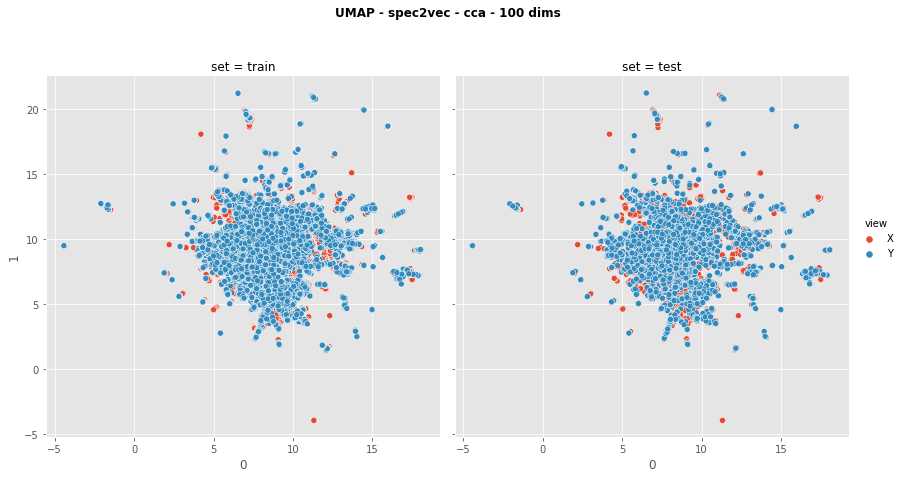

In [17]:
plot_views_per_set(df_umap, "UMAP")

In [18]:
def filter_on_top_n_classes(this_df, num_classes=10):
    """Only keep the top n most abundant classes."""
    top_classes = this_df.cf_class.value_counts().nlargest(num_classes).index.tolist()
    this_df = this_df[this_df.cf_class.isin(top_classes)]
    this_df = this_df.reset_index(drop=True)
    return this_df

# Filter top 10 classes to simplify visualisations
df_umap_reduced = filter_on_top_n_classes(df_umap)

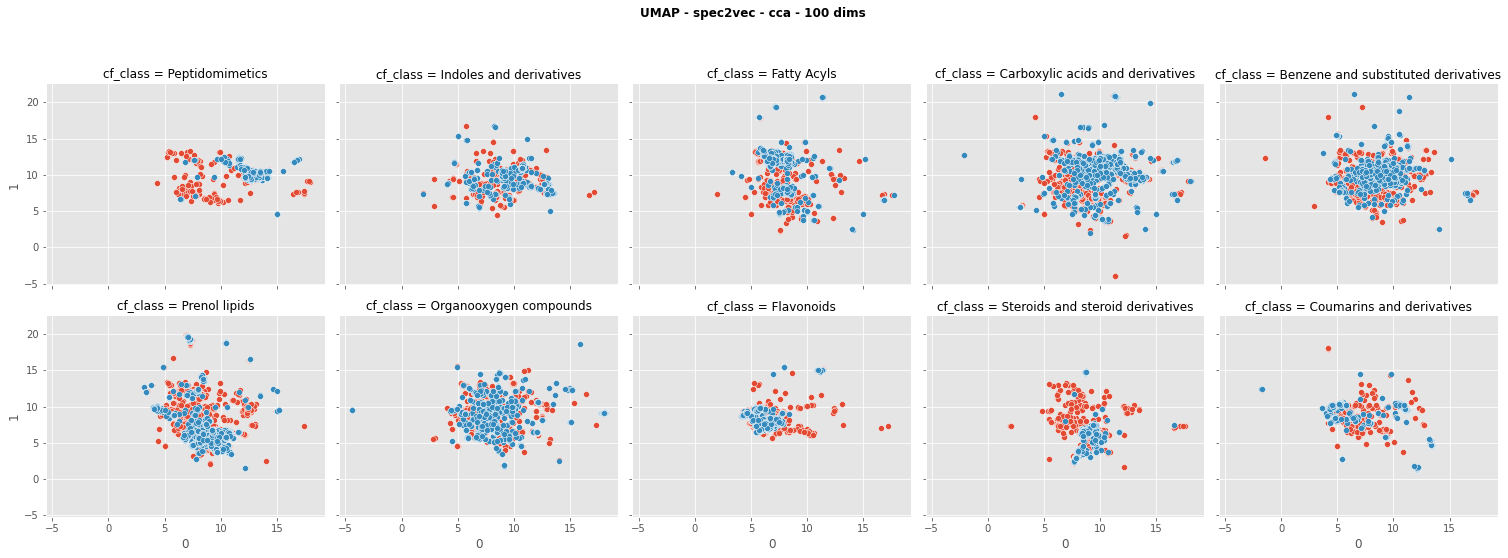

In [19]:
plot_per_class(df_umap_reduced, "UMAP", "view")

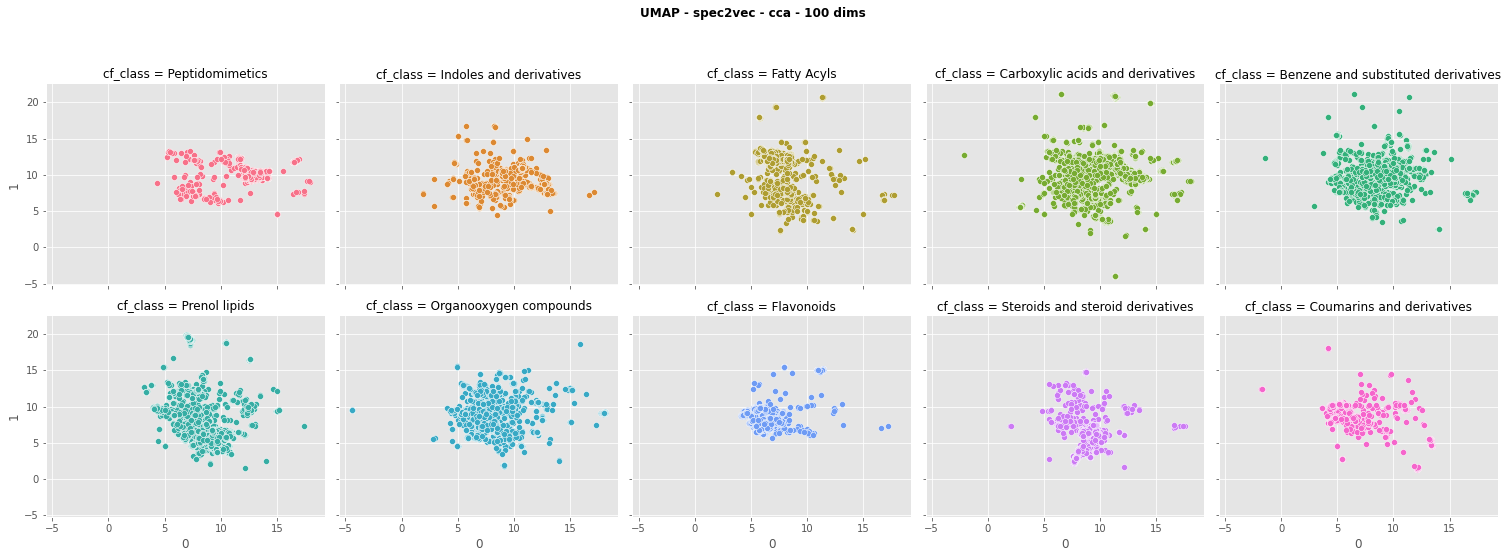

In [20]:
plot_per_class(df_umap_reduced, "UMAP", "cf_class")

### PCA

In [21]:
from sklearn.decomposition import PCA

# Init PCA and transform
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_cca)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.01051643 0.01037128]


In [22]:
df_pca = pd.concat([pd.DataFrame(pca_result), df_meta], axis=1)

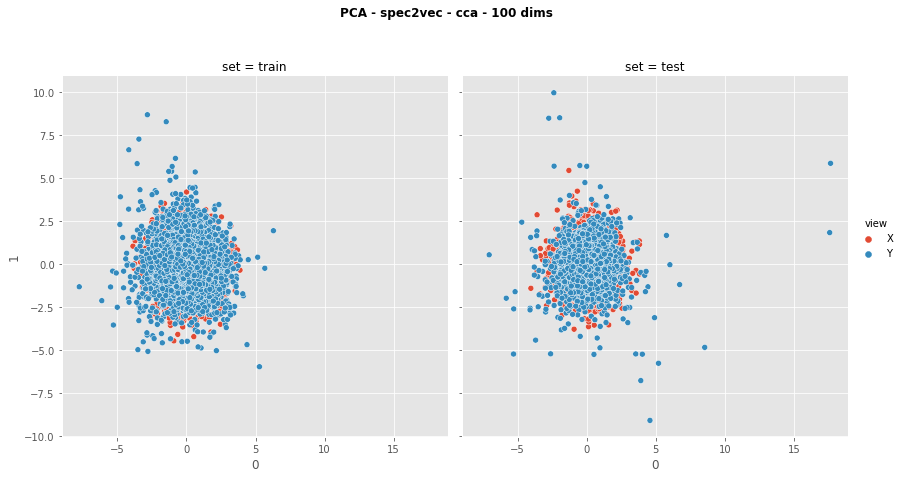

In [23]:
plot_views_per_set(df_pca, "PCA")

In [24]:
df_pca_reduced = filter_on_top_n_classes(df_pca)

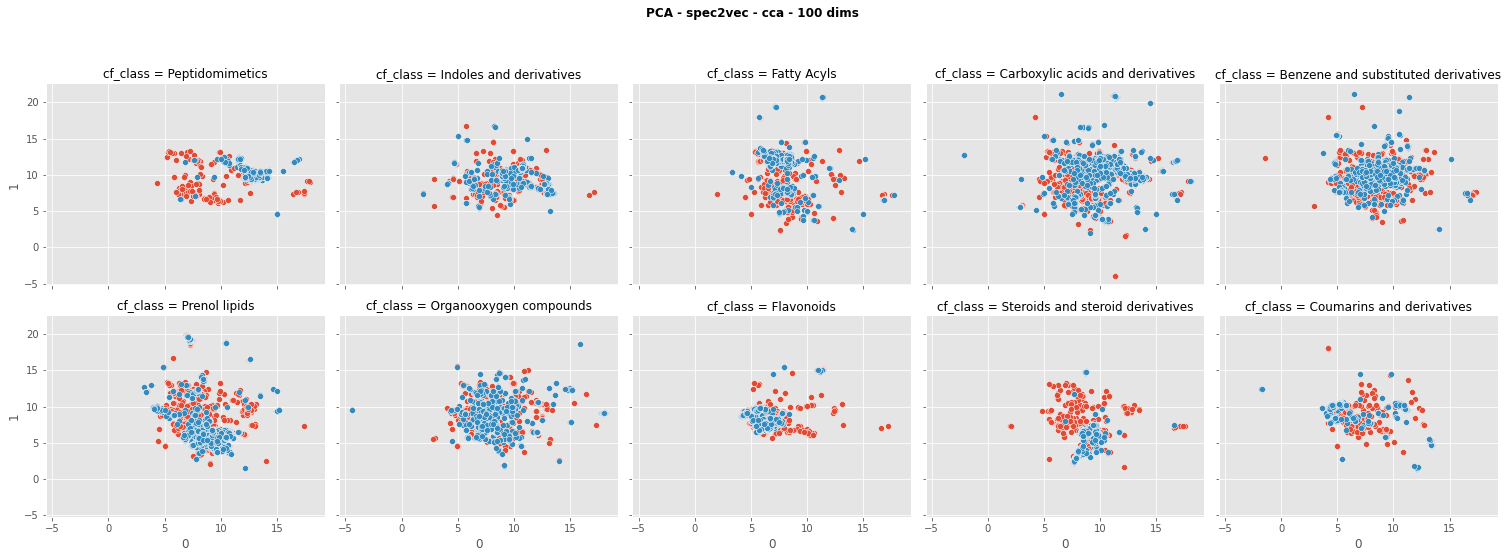

In [25]:
plot_per_class(df_pca_reduced, "PCA", "view")

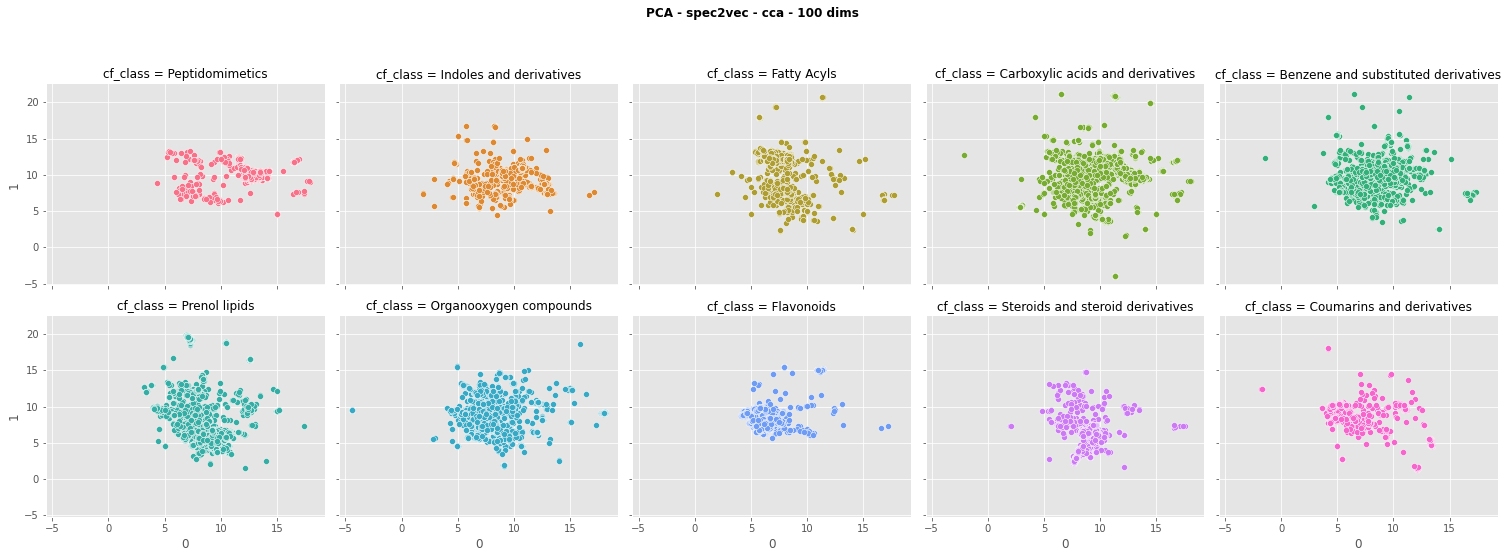

In [26]:
plot_per_class(df_pca_reduced, "PCA", "cf_class")

### T-SNE

In [27]:
import time
from sklearn.manifold import TSNE

# Init TSNE and transform
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_cca)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/home/unen004/nobackup/miniconda3/envs/matchms/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/unen004/nobackup/miniconda3/envs/matchms/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 30290 samples in 0.002s...
[t-SNE] Computed neighbors for 30290 samples in 22.428s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30290
[t-SNE] Computed conditional probabilities for sample 2000 / 30290
[t-SNE] Computed conditional probabilities for sample 3000 / 30290
[t-SNE] Computed conditional probabilities for sample 4000 / 30290
[t-SNE] Computed conditional probabilities for sample 5000 / 30290
[t-SNE] Computed conditional probabilities for sample 6000 / 30290
[t-SNE] Computed conditional probabilities for sample 7000 / 30290
[t-SNE] Computed conditional probabilities for sample 8000 / 30290
[t-SNE] Computed conditional probabilities for sample 9000 / 30290
[t-SNE] Computed conditional probabilities for sample 10000 / 30290
[t-SNE] Computed conditional probabilities for sample 11000 / 30290
[t-SNE] Computed conditional probabilities for sample 12000 / 30290
[t-SNE] Computed conditional probabilities for s

In [28]:
df_tsne = pd.concat([pd.DataFrame(tsne_results), df_meta], axis=1)

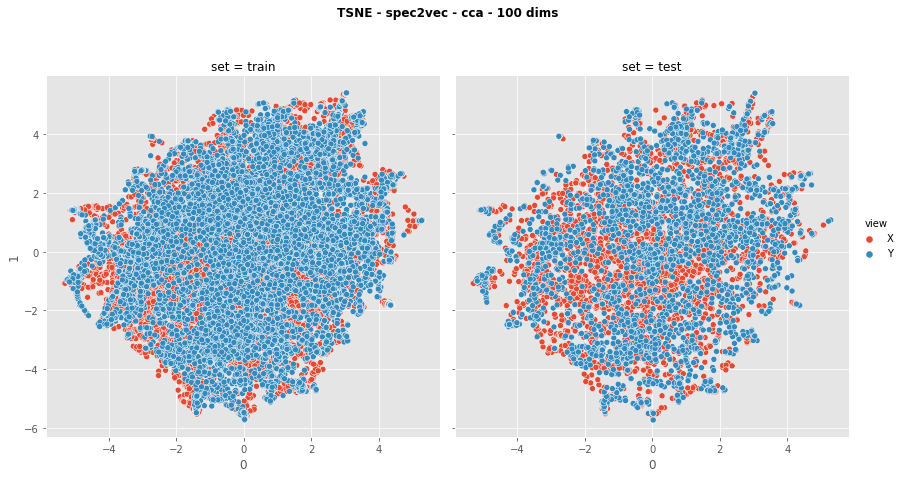

In [29]:
plot_views_per_set(df_tsne, "TSNE")

In [30]:
df_tsne_reduced = filter_on_top_n_classes(df_tsne)

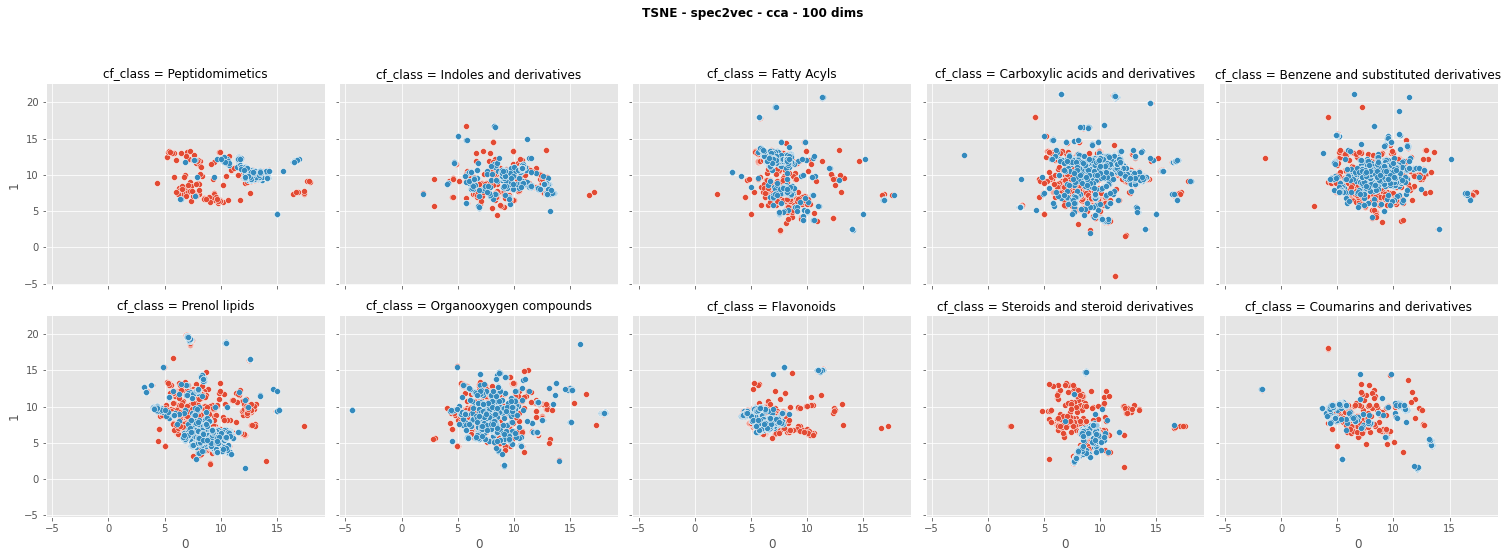

In [31]:
plot_per_class(df_tsne_reduced, "TSNE", "view")

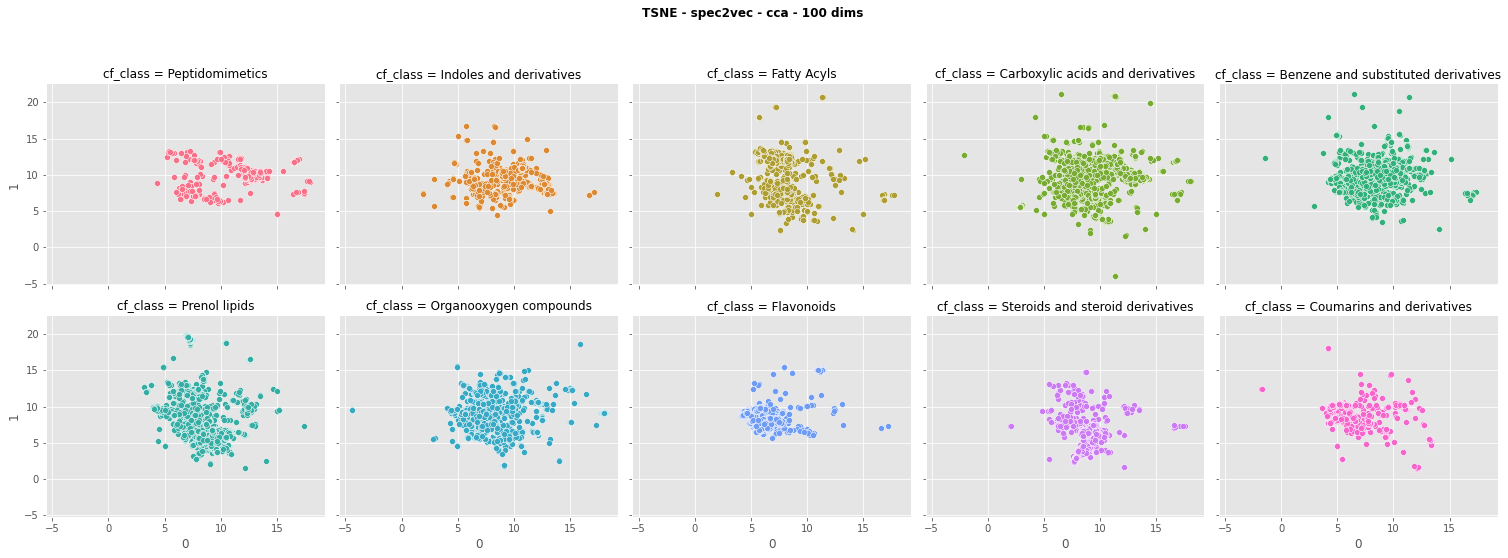

In [32]:
plot_per_class(df_tsne_reduced, "TSNE", "cf_class")

### PCA + TSNE

In [33]:
# Init PCA and transform
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df_cca)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.5063246716220237


In [34]:
# Init TSNE and transform
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/home/unen004/nobackup/miniconda3/envs/matchms/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/unen004/nobackup/miniconda3/envs/matchms/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 72.94176840782166 seconds


In [35]:
df_tsne_pca = pd.concat([pd.DataFrame(tsne_pca_results), df_meta], axis=1)

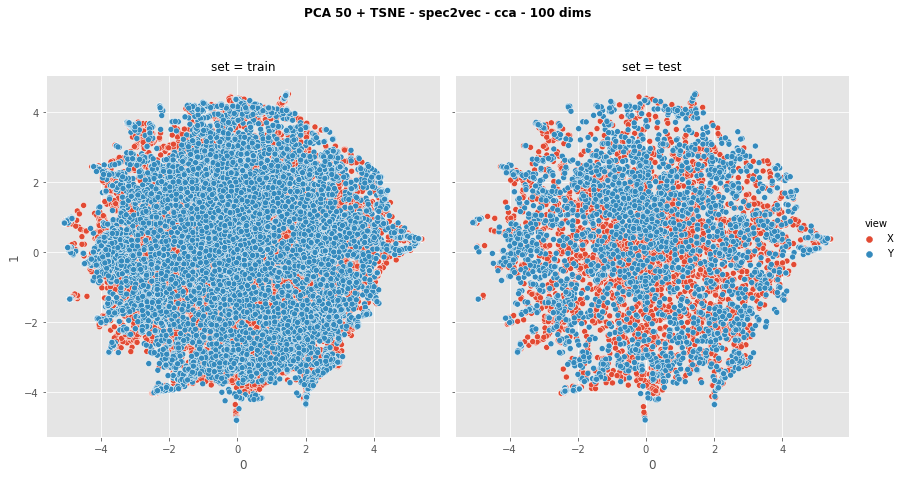

In [36]:
plot_views_per_set(df_tsne_pca, "PCA 50 + TSNE")

In [37]:
df_tsne_pca_reduced = filter_on_top_n_classes(df_tsne_pca)

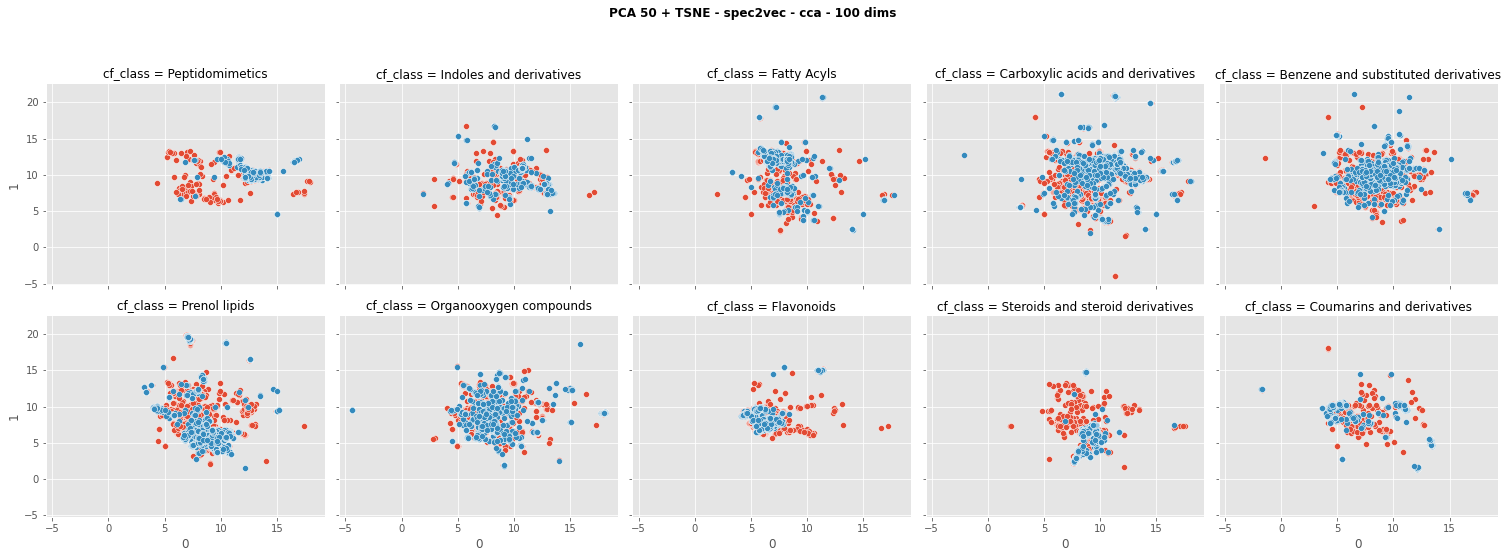

In [38]:
plot_per_class(df_tsne_pca_reduced, "PCA 50 + TSNE", "view")

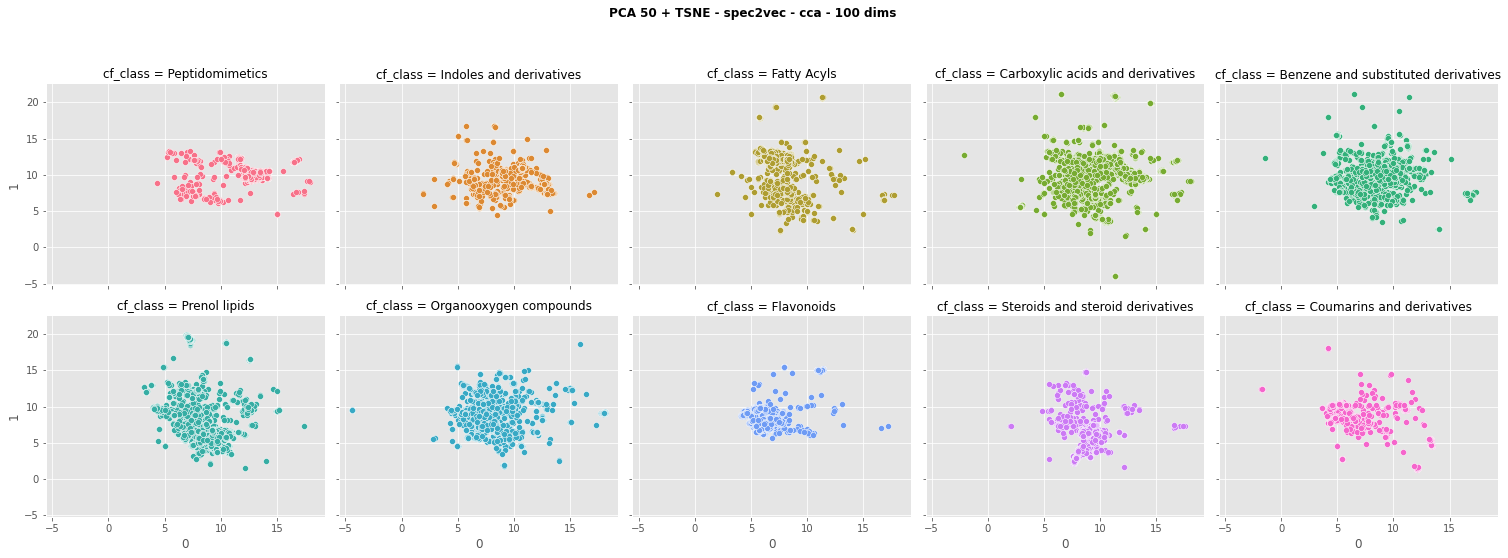

In [39]:
plot_per_class(df_tsne_pca_reduced, "PCA 50 + TSNE", "cf_class")